In [ ]:
import os
import warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducibility
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore")  # to clean up output cells

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load training and validation sets
base_dir = '/content/drive/MyDrive/A_Stage/BDDS3CB'
ds_train_ = image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=150,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    os.path.join(base_dir, 'val'),
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=150,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Mounted at /content/drive
Found 1600 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

model = keras.Sequential([
    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                  input_shape=[128, 128, 3]),
    layers.MaxPool2D(),

    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dropout(0.05),
    layers.Dense(1, activation='sigmoid'),
])


In [ ]:
import os
import warnings
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
# Charger le modèle pré-entraîné MobileNetV2 avec les poids ImageNet
base_model = MobileNetV2(input_shape=(128, 128, 3),
                         include_top=False,
                         weights='imagenet')

# Geler les poids du modèle pré-entraîné
base_model.trainable = False
# Ajouter les couches supplémentaires pour l'entraînement
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(6, activation='relu')(x)
x = Dropout(0.05)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=predictions)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=200,
)

Epoch 1/200
11/11 [==============================] - 254s 15s/step - loss: 0.7473 - binary_accuracy: 0.4794 - val_loss: 0.7112 - val_binary_accuracy: 0.5200
Epoch 2/200
11/11 [==============================] - 1s 100ms/step - loss: 0.6618 - binary_accuracy: 0.5906 - val_loss: 0.6393 - val_binary_accuracy: 0.6350
Epoch 3/200
11/11 [==============================] - 1s 122ms/step - loss: 0.5850 - binary_accuracy: 0.7156 - val_loss: 0.5768 - val_binary_accuracy: 0.7410
Epoch 4/200
11/11 [==============================] - 1s 126ms/step - loss: 0.5221 - binary_accuracy: 0.7900 - val_loss: 0.5228 - val_binary_accuracy: 0.8060
Epoch 5/200
11/11 [==============================] - 1s 96ms/step - loss: 0.4614 - binary_accuracy: 0.8506 - val_loss: 0.4770 - val_binary_accuracy: 0.8240
Epoch 6/200
11/11 [==============================] - 1s 97ms/step - loss: 0.4148 - binary_accuracy: 0.8825 - val_loss: 0.4389 - val_binary_accuracy: 0.8450
Epoch 7/200
11/11 [==============================] - 1s 97ms

In [ ]:
print(history.history.keys())


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


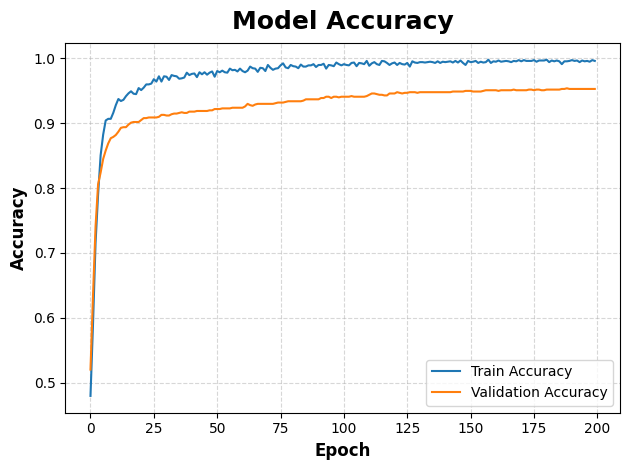

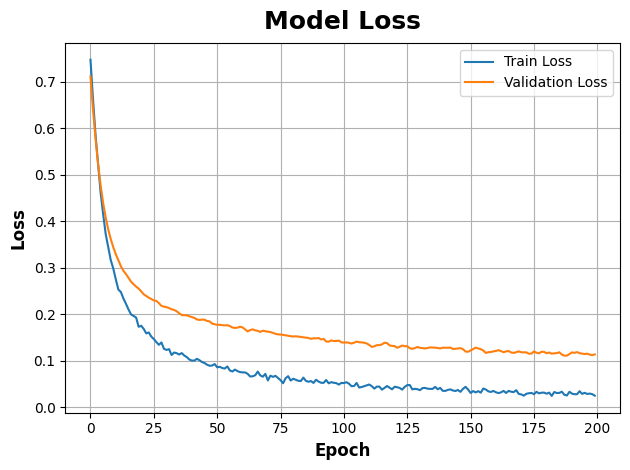

In [ ]:
# Plot accuracy vs epochs
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



# Plot loss vs epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Fonction pour prétraiter l'image d'entrée
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normaliser l'image
    return img

# Fonction pour faire des prédictions sur l'image d'entrée
def predict_image(img_path):
    img = preprocess_image(img_path)
    predictions = model.predict(img)
    if predictions[0] > 0.5:
        return "Malade"
    else:
        return "Sain"

# Chemin de l'image d'entrée
#input_image_path = '/content/drive/MyDrive/A_Stage/BDDS3CB/val/1_malade/val_esophagitis_ (45).jpg'
input_image_path = '/content/drive/MyDrive/A_Stage/BDDS3CB/val/0_normal/val_normal_ (45).jpg'

# Prédire la classe de l'image d'entrée
prediction = predict_image(input_image_path)

# Afficher la prédiction
print("L'image d'entrée est :", prediction)
